# Segmentation : FPN

FPN models are taken from `pytorch segmentation models library`

- Since it contains dataloaders for oxford pet dataset library, the datasets locally available are converted to those (currently in json masking datasets)

- Contraints 
    ```
    - Images have the same size 
    - Image h and w divisible by 32 
    - Images have correct axes order 

    - Masks Have same sizes as images 
    - O bg, 1 target class 
    -  Even if mask don't have channels, you need it. Convert each mask from HW to 1HW format for binary segmentation (expand the first dimension).
    ```

## Imports + Essentials 

In [2]:
# # pytorch 
# ! pip3 install torch torchvision torchaudio

# # segmentation dependencies 
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning
# !pip install pandas 

In [3]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader


import sys  
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import json
import io
import base64
import numpy as np
import PIL
from PIL import Image
from shapely.geometry import Polygon
import rasterio.features
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
import random


import shutil
from tqdm import tqdm
from urllib.request import urlretrieve



In [4]:
# Set a path for the dataset
datasetLocation = Path('../dataset/dfl-bl-annotated-frames/') # Looks for json files
datasetLocation = datasetLocation.resolve()

outputLocation = Path('../dataset/dfl-bl-annotated-frames-fpn-1/')
outputLocation = outputLocation.resolve()

outputAnnotationsLocation = outputLocation/'annotations'
outputAnnotationsTrimapLocation = outputAnnotationsLocation/'trimaps'
outputImagesLocation = outputLocation/'images'

TARGET_CLASS = '1' 
TRAIN_SPLIT = 0.9

## Data Preprocessing 
### `only run when dataset does not exist, only scraped and annotated does `
__ONLY works for json types of dataset__

- Creates the following structure 
    ```
    outputfolder
        /images
            1.png
            ...
        /annotations
            /trimaps
                1.png
                ...
    
    ```


In [2]:
def img_b64_to_arr(img_b64):
    f = io.BytesIO()
    f.write(base64.b64decode(img_b64))
    img_arr = np.array(Image.open(f))
    return img_arr

In [ ]:
# Creating Dataset Skeleton

for location in [outputLocation,outputAnnotationsLocation,outputAnnotationsTrimapLocation,outputImagesLocation]:
    if os.path.exists(location):
        print(f'{str(location)} does exist, continuing')
    else:
        print(f'{str(location)} does not exist, creating')
        os.mkdir(location)

In [16]:
onlyFiles = [f for f in listdir(datasetLocation) if isfile(join(datasetLocation, f))]
jsonFiles = [f for f in onlyFiles if '.json' in f]
print(f'Number of json files found: {len(jsonFiles)}')

Number of json files found: 228


In [ ]:
# Creating the Dataset 
for json_file in tqdm(jsonFiles):
    jsonLoc = datasetLocation/json_file
    jsonFile = open (jsonLoc, "r")
    jsonFile = json.load(jsonFile)
    
    # Polygon for field 
    label1 = [i for i in jsonFile['shapes'] if i['label']==TARGET_CLASS]
    field_poly = label1[0]['points']

    
    # original image
    im_b64 = jsonFile['imageData']
    im_np = img_b64_to_arr(im_b64)
    im = Image.fromarray(im_np)
    im = im.save(str(outputImagesLocation/jsonLoc.stem) + '.png')
    
    
    # mask 
    poly = Polygon(field_poly)
    im_mask_np = rasterio.features.rasterize([poly], out_shape=(im_np.shape[0],im_np.shape[1]))
    im_mask = Image.fromarray(im_mask_np)
    im_mask = im_mask.save(str(outputAnnotationsTrimapLocation/jsonLoc.stem) + '.png')

In [57]:
# Creating the train test split 
fileStems = [x.split('.')[0] for x in jsonFiles]
random.shuffle(fileStems)

trainval = fileStems[:int(TRAIN_SPLIT*len(fileStems))]
test = fileStems[int(len(fileStems)*TRAIN_SPLIT):]

trainval = pd.DataFrame(trainval)
test = pd.DataFrame(test)



In [58]:
test.to_csv(outputAnnotationsLocation/'test.csv')
trainval.to_csv(outputAnnotationsLocation/'trainval.csv')

## Writing Data Loaders 

In [5]:
#  Ref : https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/datasets/oxford_pet.py

class OxfordPetDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations", "trimaps")

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        image_path = os.path.join(self.images_directory, filename + ".png")
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))

        trimap = np.array(Image.open(mask_path))
        # mask = self._preprocess_mask(trimap)
        mask = trimap.astype(np.float32)

        sample = dict(image=image, mask=mask, trimap=trimap)
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def _read_split(self):
        split_filename = "test.csv" if self.mode == "test" else "trainval.csv"
        split_filepath = os.path.join(self.root, "annotations", split_filename)
        
        
        
        df = pd.read_csv(split_filepath)
        filenames = df['0'].tolist()
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        return filenames


class SimpleOxfordPetDataset(OxfordPetDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(Image.fromarray(sample["image"]).resize((256, 256), Image.LINEAR))
        mask = np.array(Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST))
        trimap = np.array(Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

        return sample


class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        return

    with TqdmUpTo(
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=os.path.basename(filepath),
    ) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    dst_dir = os.path.splitext(filepath)[0]
    if not os.path.exists(dst_dir):
        shutil.unpack_archive(filepath, extract_dir)

In [6]:
# download data
root = str(outputLocation)

In [7]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

In [8]:
# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 184
Valid size: 21
Test size: 23


/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_24306/1337751256.py:66: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = np.array(Image.fromarray(sample["image"]).resize((256, 256), Image.LINEAR))
/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_24306/1337751256.py:67: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = np.array(Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST))
/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_24306/1337751256.py:68: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  trimap = np.array(Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST))


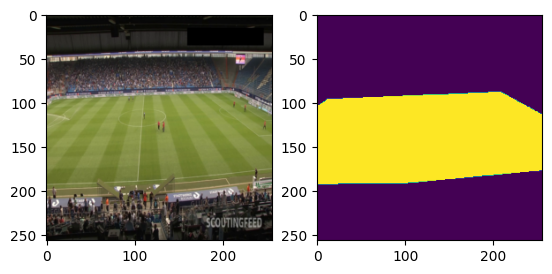

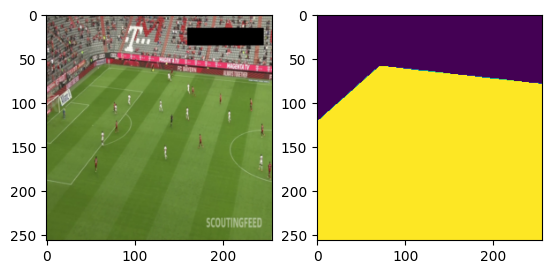

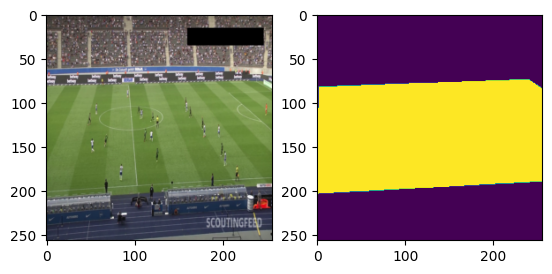

In [9]:
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [10]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [11]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/flipflops/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/flipflops/engineer/soccerEye/experiments/lightning_logs

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SimpleOxfordPetDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Caskroom/miniconda/base/envs/se/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SimpleOxfordPetDataset' on <module '__main__' (built-in)>
Traceback (most recent call last

RuntimeError: DataLoader worker (pid(s) 24332, 24335, 24336) exited unexpectedly